# Unique Insertion Reads Counter

## Overview:
- Intended to use for counting number of unique UMIs given putative insertion reads (single-end only). 
- Reads are filtered to contain both the donor sequence and the target sequence with fuzzy string matching
- Global parameters are at the top, files are read in as .fastq files, sample sheet gives donor/target sequence, RC, and file/sample names
- Can also plot the distribution of UMI read counts, plot insertion site positions, and return .fastq files containing insertion reads
- Optional parallelization across samples for faster run time

### Modified from Alim/Makoto's original script

In [6]:
# Parameters to modify

#General Params
UMI_start = 50 # Distance from start of donor sequence to start of UMI
UMI_length = 5 # Length of UMI to count
experiment_marker = ".fastq" #File format to read in (Doesn't actually work for anything but .fastq :P )
paired_end = False #Paired-end or single-end, still under development

#Fuzzy string matching matches more reads, but also takes longer to run
allow_errors = False # Setting for whether to allow errors in target/donor sequence match, T/F
donor_errors = 0 # Number of errors (indels, substitions) to allow between reads and donor sequence to match
target_errors = 0 # Number of errors (indels, substitions) to allow between reads and target sequence to match

#Optional filtering for insertion position
filter_insert_position = True # Setting for whether to threshold allowed insertion positions, T/F
insert_pos_min = 0 # Minimum insertion position, inclusive, relative to start of donor if filtering on
insert_pos_max = 120  # Maximum insertion position, inclusive, relative to start of donor if filtering on

In [7]:
#Import helpful packages
import csv
import itertools
import sys
import os
import math
import numpy as np
from tqdm.notebook import tnrange, tqdm_notebook, tqdm

#Packages for data analysis and plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#Packages for sequence parsing
import regex as re #Different from re from Alim's script, allows fuzzy matching
from Bio import SeqIO

#Packages for parallelization
from multiprocess import Pool
import psutil
from functools import partial

## Helper Functions

In [8]:
def sort_R_file(file_list):
    '''
    Sorts read files by name to determine forward/reverse read (relevant for paired end)
    '''
    sorted_list = ['','']
    for file in file_list:
        if 'R1_' in file:
            sorted_list[0] = file
        else:
            sorted_list[1] = file
    return sorted_list

In [9]:
def insertion_counter(fastq_f_r1, target, donor, rev_com):
    '''
    Processes .fastq files to count insertion reads and output statistics as well as dictionary of UMIs and counts,
        insertion positions, insertion positions for each UMI, and reads to generate a .fastq
    Inputs:
        fastq_f_r1: file name of relevant fastq file, as a string
        target: target sequence to match, as a string
        donor: donor sequence to match, as a string
        rev_com: reverse complement param, as a boolean (int of 0 or 1)
        Implicitly takes in many params related to UMI position, length, fuzzy string matching, and filtering
    Outputs:
        Prints # of reads, # of insertion reads, # of unique UMIs
        insertion_dict: stores UMIs as keys with counts per UMI as values
        insert_pos_list: list of insertion positions
        UMI_insert_pos_list: list of insertion positions deduplicated by UMI
        insertion_read_list: list of reads that are insertions, for later output as a .fastq for examination
    '''
    # Initialize variables
    num_reads = 0
    insertion_reads = 0
    unique_insertion_reads = 0
    insertion_dict = {} 
    insert_pos_list = [] 
    UMI_insert_pos_list = []
    insertion_read_list = []
    
    # Process input strings and define regexes
    target = target.upper()
    donor = donor.upper()   
    if allow_errors:
        target_error_string = "{"+f"e<={target_errors}"+"}"
        donor_error_string = "{"+f"e<={donor_errors}"+"}"     
        target_pattern = f"(?e)({target}){target_error_string}"
        donor_pattern = f"(?e)({donor}){donor_error_string}"
    else:
        target_pattern = target
        donor_pattern = donor


    # Extract and iterate through reads from .fastq file
    readiter_f = SeqIO.parse(fastq_f_r1, "fastq")
    pbar2 = tqdm(readiter_f)
    for record_f in pbar2:
        num_reads += 1
        read_sequence_f = str.upper(str(record_f.seq))
        if rev_com:
            read_sequence_f = str.upper(str(record_f.seq.reverse_complement()))
            
        # Search for target and donor match, store and record relevant information
        target_match = re.search(target_pattern, read_sequence_f)
        if target_match:
            donor_site = re.search(donor_pattern, read_sequence_f)
            if donor_site:
                    target_insertion = donor_site.start()-target_match.start()
                    UMI_seq = read_sequence_f[donor_site.start()+UMI_start:donor_site.start()+UMI_start+UMI_length]
                    if (insert_pos_min <= target_insertion <= insert_pos_max) or (not filter_insert_position):
                        insertion_reads +=1
                        insert_pos_list.append(target_insertion)
                        insertion_read_list.append(record_f)
                        if UMI_seq not in insertion_dict:
                            unique_insertion_reads += 1
                            UMI_insert_pos_list.append(target_insertion)                        
                        insertion_dict[UMI_seq] = insertion_dict.get(UMI_seq, 0) + 1
    pbar2.close()
                
    # Print Stats
    print(num_reads,"total reads, ",insertion_reads," insertion reads ", unique_insertion_reads, "unique insertion_reads" )
    
    return [insertion_dict, insert_pos_list, UMI_insert_pos_list, insertion_read_list]

In [10]:
def insertion_counter_parallel(sample_index):
    '''
    Helper function to parallelize insertion counter
    Processes .fastq files to count insertion reads and output statistics as well as dictionary of UMIs and counts,
        insertion positions, insertion positions for each UMI, and reads to generate a .fastq
    Inputs:
        sample_index: index of sample as string (e.g. "A12")
        Implicitly takes in many params related to UMI position, length, fuzzy string matching, and filtering
        Also takes in params that are in df containing sample information
    Outputs:
        Prints # of reads, # of insertion reads, # of unique UMIs
        insertion_dict: stores UMIs as keys with counts per UMI as values
        insert_pos_list: list of insertion positions
        UMI_insert_pos_list: list of insertion positions deduplicated by UMI
        insertion_read_list: list of reads that are insertions, for later output as a .fastq for examination
    '''
    #Get sample data and input into insertion_counter
    sample = samples.loc[sample_index,:]

    fastq_f_r1 = sample['Forward']
    target = sample['Target']
    donor = sample['Donor']
    rev_com = sample['Reverse Complement']
    intermediate_data = insertion_counter(fastq_f_r1, target, donor, rev_com)
    print(sample['Name'])
    return [sample['Name'], intermediate_data]

In [11]:
def insertion_pos_plot(sample_name, deduplicated_by_UMI, print_out):
    '''
    Takes in sample names and a few params and plots plot of insertion positions
    Inputs:
        sample_name = sample name as string
        deduplicated_by_UMI = Boolean for whether to look at insertion pos with or without deduplication
        print_out = Boolean for whether to print out list of insertion positions or not
    Outputs:
        Graph of insertion positions
        Prints out relevant insertion pos list dependent on print_out parameter
    '''
    #Acquire data
    if sample_name not in data:
        raise ValueError("Sample not found")
    if deduplicated_by_UMI:
        insertion_positions = np.array(data[sample_name][2])
    else:
        insertion_positions = np.array(data[sample_name][1])

    #Set up plot
    left_of_first_bin = insertion_positions.min() - 0.5
    right_of_last_bin = insertion_positions.max() + 0.5
    plt.figure(figsize=(9, 6)) 
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)  
    plt.xlabel("Insertion Position", fontsize=16)  
    plt.ylabel("Count", fontsize=16)
    plt.hist(insertion_positions, np.arange(left_of_first_bin, right_of_last_bin + 1, 1), color="#3F5D7D")
    plt.show()
    
    #Print data if desired
    if print_out:
        print(*insertion_positions)

In [12]:
final_df = pd.DataFrame(columns = list(np.arange(0,121,1)), dtype=object)
final_df

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120


In [13]:
def insertion_pos_to_CSV(output_file, min_pos, max_pos, deduplicated_by_UMI):
    '''
    Iterates through samples and outputs read counts for a given window of insertion positions as .csv
    Implicitly assumes that data has been generated by one of the insertion counter functions
    Inputs:
        output_file = output file name as string
        min_pos = minimum insertion position to consider as window
        max_pos = maximium insertion position to consider as window
        deduplicated_by_UMI = Boolean for whether to look at insertion pos with or without deduplication
        
    Outputs:
        .csv file of the insertion positions in same working directory
    '''    
    final_df = pd.DataFrame(columns = list(np.arange(min_pos,max_pos+1,1)), dtype=object)
    for sample in samples.index.tolist():
        sample_name = samples.loc[sample][0]
        counters = []
        if deduplicated_by_UMI:
            insertion_positions = np.array(data[sample_name][2])
        else:
            insertion_positions = np.array(data[sample_name][1])
        for x in np.arange(min_pos,max_pos+1,1):
            counters.append(np. count_nonzero(insertion_positions==x))
        final_df.loc[sample_name]=counters
    if ".csv" not in output_file:
        raise ValueError("File name not valid")
    final_df.to_csv(output_file)    
    return final_df
        
        

In [14]:
def UMI_dist_plot(sample_name, scale, print_out, print_counts):
    '''
    Takes in sample name and plots plot of read counts per UMI
    Inputs:
        sample_name = sample name as string
        scale = "Log" or "Linear"
        print_out = Boolean for whether to print out UMIs or not
        print_counts = Boolean for whether to print out UMI counts or not
    Outputs:
        Graph of insertion positions
        Prints out relevant data dependent on print parameters
    '''
    #Acquire data
    if sample_name not in data:
        raise ValueError("Sample not found")
    else:
        sample_UMI_dict = data[sample_name][0]

    
    #Set up data for plot
    counts = []
    UMIlabels = []
    for UMI, count in sample_UMI_dict.items():
        UMIlabels.append(UMI)
        counts.append(count)
    sorted_inds = np.array(counts).argsort()
    sorted_counts = np.array(counts)[sorted_inds[::-1]]
    sorted_UMIlabels = np.array(UMIlabels)[sorted_inds[::-1]]
    
    #Set up plot
    plt.figure(figsize=(20, 8)) 
    plt.bar(np.arange(len(sorted_counts)),sorted_counts)
    plt.xticks(fontsize=2)  
    plt.yticks(fontsize=14)
    if scale == "Log":
        plt.yscale('log')
    elif scale != "Linear":
        raise ValueError("Scale parameter is not defined correctly")
    plt.xlabel("UMI # sorted by count", fontsize=16)  
    plt.ylabel("Read Count", fontsize=16)
    plt.show()

    #Print data if desired
    if print_out:
        if print_counts:
            print(*zip(sorted_UMIlabels, sorted_counts))   
        else:
            print(*sorted_UMIlabels)
    elif print_counts:
        print(*sorted_counts)

In [15]:
def write_fastq(sample_name, file_name):
    '''
    Takes in sample name and writes reads to fastq file
    Inputs:
        sample_name = sample name as string
        file_name = output file name as string
    Outputs:
        .fastq file in same working directory containing filtered reads
    '''
    #Acquire data
    if sample_name not in data:
        raise ValueError("Sample not found")
    else:
        sample_reads = data[sample_name][3]

    #Write reads to file
    if ".fastq" not in file_name:
        raise ValueError("File name not valid")
    with open(file_name, "w") as output_handle:
        SeqIO.write(sample_reads, output_handle, "fastq")
    print(f"Reads written to: {file_name}")

## Main Script

In [16]:
#Lists and stores names of all unzipped .fastq files from current folder
#Note: identifies samples by second term in .fastq name (applies to standard lab BCs, but not everyone's)
cwd = os.getcwd()
files = os.listdir(cwd)
file_dict = {}
for file in files:
    if experiment_marker in file and '.gz' not in file:
        sample = file.split('_')
        try: 
            if sample[1] in file_dict:
                file_dict[sample[1]].append(file)
            else:
                file_dict[sample[1]] = [file]
        except:
            raise ValueError("Folder contains .fastq file not fitting correct format")
print(file_dict)

{'F1': ['P18_F1_S1693_R1_001.fastq'], 'F2': ['P18_F2_S1694_R1_001.fastq']}


In [17]:
#Import Sample Sheet
samples = pd.read_csv('Analysis_Sample_Sheet.csv', index_col = 0)
for sample in samples.index.tolist():
    fwd_file, rev_file = sort_R_file(file_dict[sample])
    samples.loc[sample,'Forward'] = fwd_file
    if paired_end:
        samples.loc[sample, 'Reverse'] = rev_file #Empty string if no reverse read
display(samples)

,Name,Target,Donor,Reverse Complement,Forward
Sample,,,,,
F1,ID1_PSP1_uL,gagaagtcatttaataaggccactgttaaacgtagatata,TGTGACTGCAACCATAAGTTGTCTATTTCG,0,P18_F1_S1693_R1_001.fastq


In [18]:
#Count insertion reads and process data for further analysis
pbar = tqdm(samples.index.tolist()[:])
data = {}
for index in pbar:
    sample = samples.loc[index,:]
    sample_data = insertion_counter(sample['Forward'], sample['Target'], sample['Donor'], sample['Reverse Complement'])
    print(sample['Name'])
    if sample['Name'] not in data:
        data[sample['Name']] = sample_data
    else:
        raise ValueError("Multiple samples with same name")
pbar.close()


961561 total reads,  5100  insertion reads  16 unique insertion_reads
ID1_PSP1_uL



In [19]:
#Optional parallelized version (should be faster than the above given enough samples, is parallelized across samples)
#Takes a bit to close the pool, but results generated quickly
data = {}
pool = Pool(psutil.cpu_count(logical=False))
for [sample_name, processed_sample_data] in pool.imap(insertion_counter_parallel, samples.index.tolist()):
    if sample_name not in data:
        data[sample_name] = processed_sample_data
    else:
        raise ValueError("Multiple samples with same name")
pool.close()


961561 total reads,  5100  insertion reads  16 unique insertion_reads
ID1_PSP1_uL


## Insertion Position Analysis

In [20]:
help(insertion_pos_plot)

Help on function insertion_pos_plot in module __main__:

insertion_pos_plot(sample_name, deduplicated_by_UMI, print_out)
    Takes in sample names and a few params and plots plot of insertion positions
    Inputs:
        sample_name = sample name as string
        deduplicated_by_UMI = Boolean for whether to look at insertion pos with or without deduplication
        print_out = Boolean for whether to print out list of insertion positions or not
    Outputs:
        Graph of insertion positions
        Prints out relevant insertion pos list dependent on print_out parameter



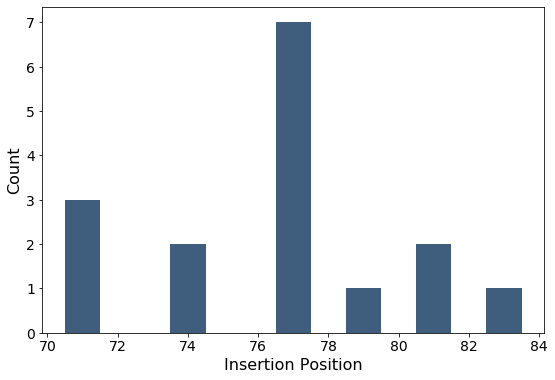

83 79 81 71 77 77 71 77 74 77 81 71 77 77 77 74


In [21]:
# Plot of insertion positions not deduplicated by UMI
insertion_pos_plot("ID1_PSP1_uL", True, True)

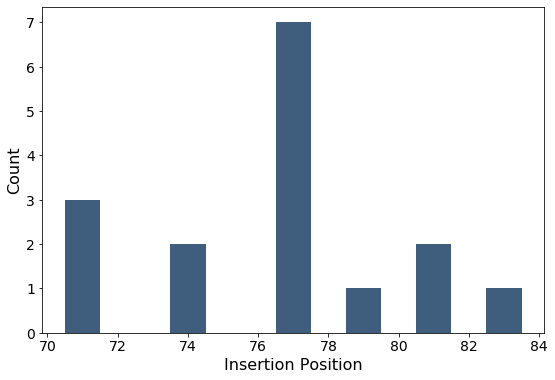

In [22]:
# Plot of insertion positions deduplicated by UMI
insertion_pos_plot("ID1_PSP1_uL", True, False)

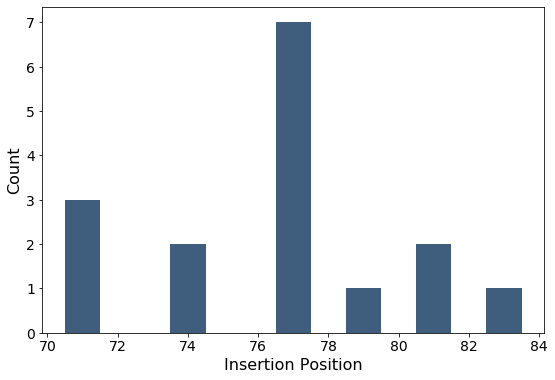

83 79 81 71 77 77 71 77 74 77 81 71 77 77 77 74


In [23]:
# Print-out of insertion positions deduplicated by UMI
insertion_pos_plot("ID1_PSP1_uL", True, True)

## UMI Read Distribution Analysis

In [24]:
help(UMI_dist_plot)

Help on function UMI_dist_plot in module __main__:

UMI_dist_plot(sample_name, scale, print_out, print_counts)
    Takes in sample name and plots plot of read counts per UMI
    Inputs:
        sample_name = sample name as string
        scale = "Log" or "Linear"
        print_out = Boolean for whether to print out UMIs or not
        print_counts = Boolean for whether to print out UMI counts or not
    Outputs:
        Graph of insertion positions
        Prints out relevant data dependent on print parameters



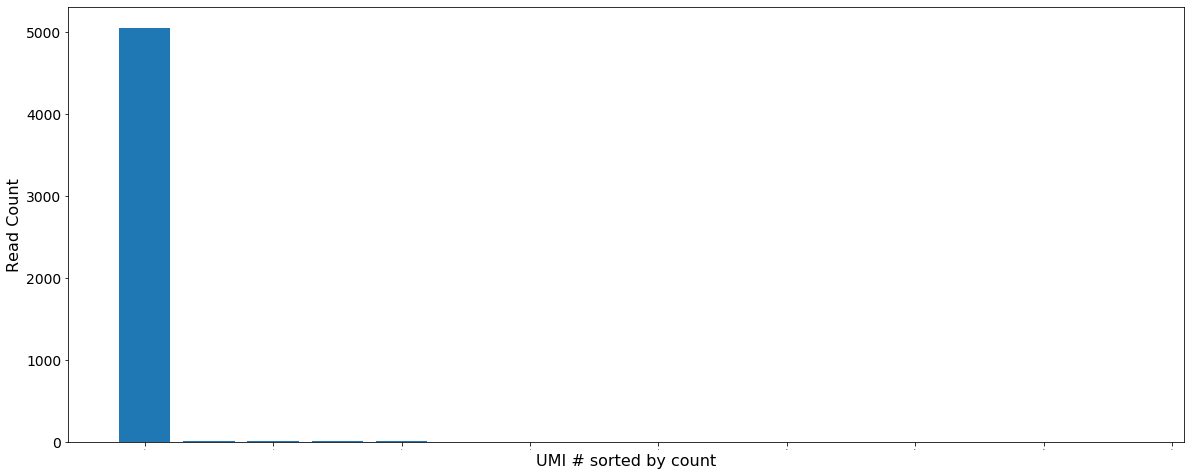

In [25]:
# UMI read plot with linear scale
UMI_dist_plot("ID1_PSP1_uL", "Linear", False, False)

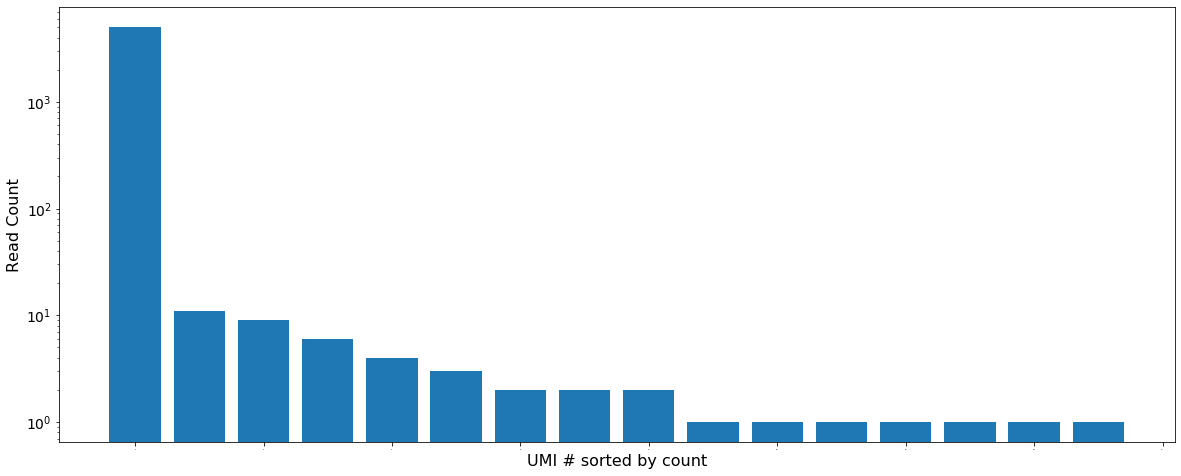

5054 11 9 6 4 3 2 2 2 1 1 1 1 1 1 1


In [26]:
# UMI read plot with linear scale
UMI_dist_plot("ID1_PSP1_uL", "Log", False, True)

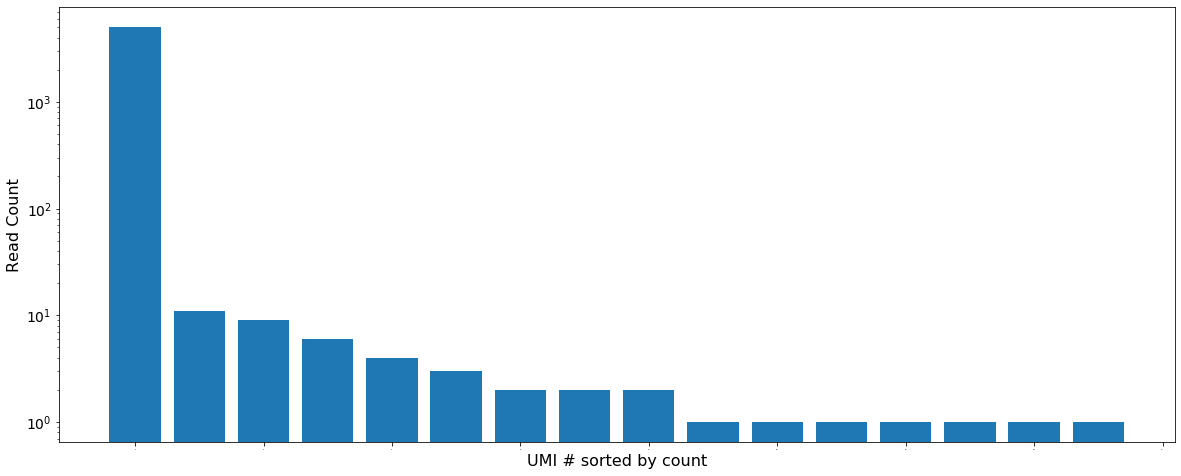

In [27]:
# UMI read plot with log scale
UMI_dist_plot("ID1_PSP1_uL", "Log", False, False)

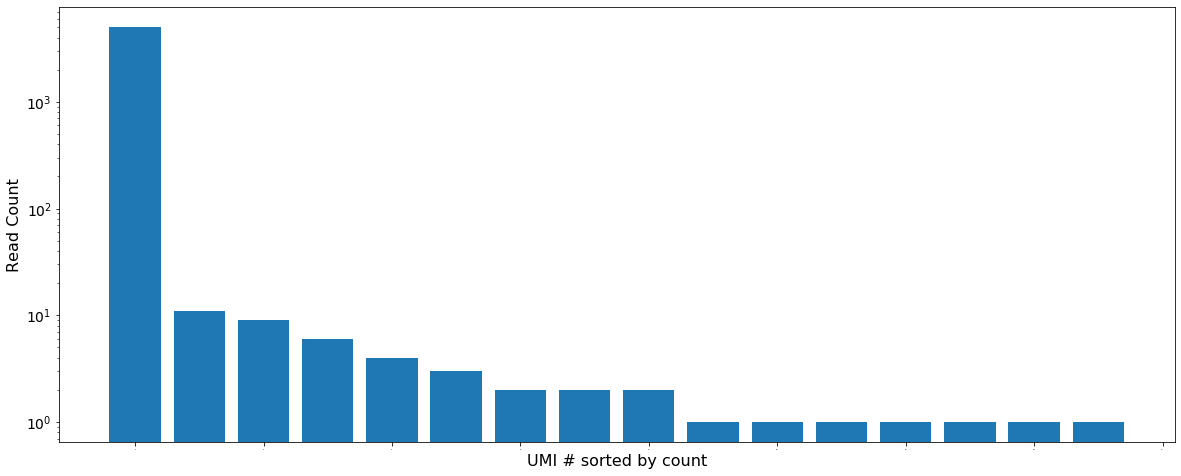

TTGGC TTGGA TTGTC TGGCT TTTGC TTGGG TTGAC TTGCC CTGGC ATGGC TAGGC TTAGC TCGGC TGGGC TAGCC TTGGT


In [28]:
# Print-out of UMIs
UMI_dist_plot("ID1_PSP1_uL", "Log", True, False)

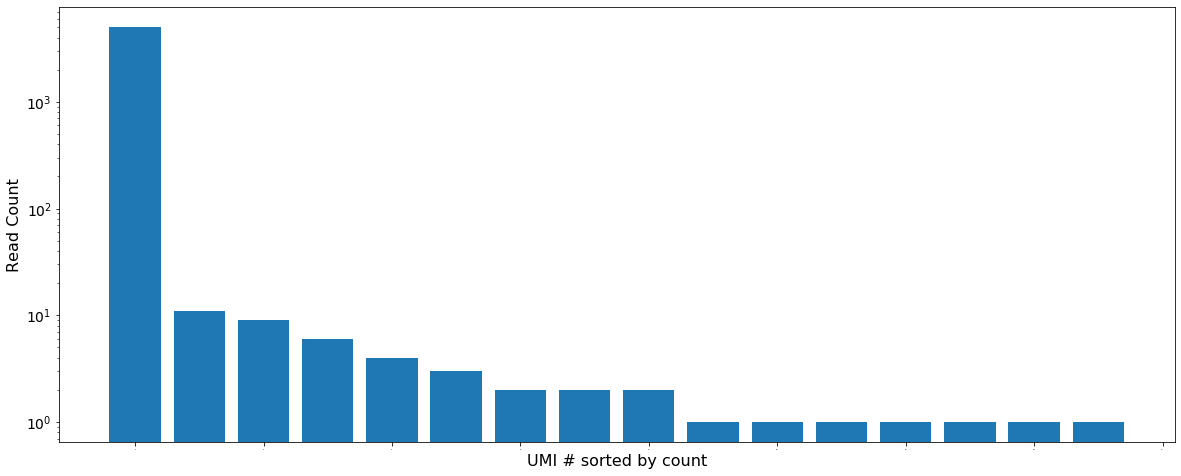

('TTGGC', 5054) ('TTGGA', 11) ('TTGTC', 9) ('TGGCT', 6) ('TTTGC', 4) ('TTGGG', 3) ('TTGAC', 2) ('TTGCC', 2) ('CTGGC', 2) ('ATGGC', 1) ('TAGGC', 1) ('TTAGC', 1) ('TCGGC', 1) ('TGGGC', 1) ('TAGCC', 1) ('TTGGT', 1)


In [29]:
# Print-out of UMIs with counts
UMI_dist_plot("ID1_PSP1_uL", "Log", True, True)

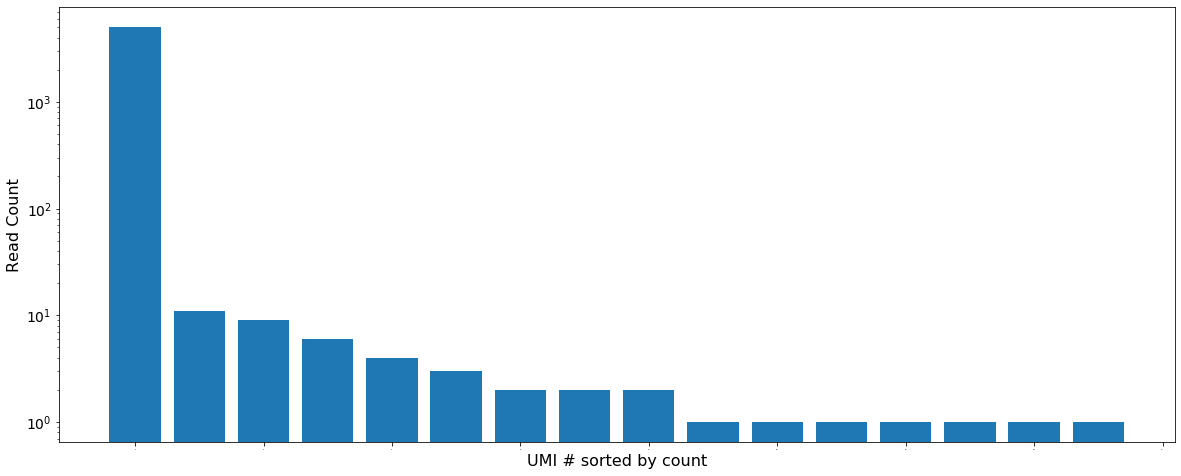

5054 11 9 6 4 3 2 2 2 1 1 1 1 1 1 1


In [30]:
# Print-out of counts only
UMI_dist_plot("ID1_PSP1_uL", "Log", False, True)

## .fastq File Output

In [31]:
help(write_fastq)

Help on function write_fastq in module __main__:

write_fastq(sample_name, file_name)
    Takes in sample name and writes reads to fastq file
    Inputs:
        sample_name = sample name as string
        file_name = output file name as string
    Outputs:
        .fastq file in same working directory containing filtered reads



In [32]:
#For this line to work correctly, create a sub-folder named InsertionReads
write_fastq("ID1_PSP1_uL", "InsertionReads//ID1_PSP1_uL.fastq")

Reads written to: InsertionReads//ID1_PSP1_uL.fastq


# Insertion Positions to .csv

In [33]:
help(insertion_pos_to_CSV)

Help on function insertion_pos_to_CSV in module __main__:

insertion_pos_to_CSV(output_file, min_pos, max_pos, deduplicated_by_UMI)
    Iterates through samples and outputs read counts for a given window of insertion positions as .csv
    Implicitly assumes that data has been generated by one of the insertion counter functions
    Inputs:
        output_file = output file name as string
        min_pos = minimum insertion position to consider as window
        max_pos = maximium insertion position to consider as window
        deduplicated_by_UMI = Boolean for whether to look at insertion pos with or without deduplication
        
    Outputs:
        .csv file of the insertion positions in same working directory



In [34]:
insertion_pos_to_CSV("Insertion_Pos.csv", 0, 121, False)

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
ID1_PSP1_uL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
